# Automatically count the lines in a page
**By Peter A. Stokes, École Pratique des Hautes Études – Université PSL**

_These are brief notes summarising the key points of image analysis and manipulation using Python. They are intended as teaching aids for the course on 'Image Processing with Python' which is part of the École d'été d'éditions numériques / humanités numériques (EDEEN). For more details see https://edeen.sciencesconf.org. They assume a pre-existing directory structure with images of Cambridge, Corpus Christi College MS 44 which can be obtained from Parker on the Web: https://parker.stanford.edu_.

This exercise is significantly more advanced than the one using PIL. It shows a (rough) way of counting the number of lines of text in the image of a manuscript page. It uses a fairly simple technique and only really works for very clean manuscripts with pretty regular lines of text.

In order to do this, we need to use more complex processes than are available in PIL. Instead, we will use very well-established libraries for numerical and data processing, NumPy and SciKit-Image.

First, we import our libraries and set up our variables as usual.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, segmentation
from skimage.io import imread, imshow
from skimage.color import rgb2grey
from scipy.signal import argrelmax, savgol_filter
import os, glob

# Save the directory and generate list of image files
directory = 'CCCC 44/'
filelist = glob.glob(directory + '*.jpg')

# Create an empty list variable for use later
lines_per_page = []

We then want to threshold the image. This means that we turn the image into a simple black and white, where dark sections (i.e. ink) are white, and light sections (i.e. background) are black. The method we use here is reproduced from 'Simple Image Segmentation with Scikit-Image': http://douglasduhaime.com/posts/simple-image-segmentation-with-scikit-image.html The details of how it works are a bit complicated, so don't worry if you don't understand it fully. In summary, though, it does the following:

1. Convert the image from colour to gray (since we don't need colour anymore).
1. Calculate the threshold level of how dark something needs to be to colour it white, and vice versa. To do this we use a built-in function.
1. Create a 'mask', that is, a map of all the pixels with value `True` if the pixel value is below the threshold, and `False` if it is above the threshold.
1. Use the built-in `segmentation.clear_border` function to remove any `True` pixels at the border of the image, as these are almost certainly just rubbish.

**You may receive a warning when you run this code**. If so then just ignore it: it's not our problem, and the code will still work.

This may also take some time, depending on the size of your image and the speed of your computer.

Grayscale image:


/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


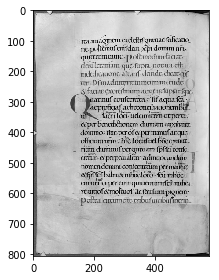

In [2]:
# Just take the first image for now. We'll deal with the rest later.
f = filelist[0]

im_rgb = imread(f)
im = rgb2grey(im_rgb)

print('Grayscale image:')
imshow(im)

Masked image:


/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


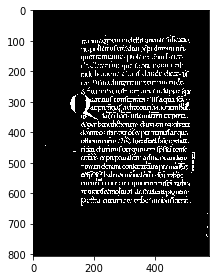

In [3]:
# Now we find a dividing line between 0 and 255. Pixels below this value
# will be black, and pixels above this value will be white.

val = filters.threshold_otsu(im)

# The mask object converts each pixel in the image to True or False
# to indicate whether the given pixel is black or white
mask = im < val

# Now we apply the mask to the image object
clean_border = segmentation.clear_border(mask)

print('Masked image:')
imshow(clean_border)

Now we want to check for recto and verso pages and flip them if necessary so that they all have the same layout. We could have done this before the thresholding but it's more efficient to do it after, since the thresholded images are much smaller than the originals (they only have one bit per pixel instead of 24 bits). The code here is the same as we've seen before, but adapted to use NumPy instead of PIL.

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


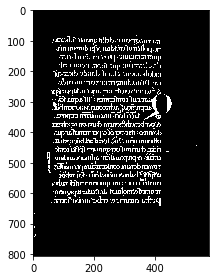

In [4]:
# Get the basename without extension
fol = os.path.splitext(os.path.basename(f))[0].lower()

# Now, flip the image if it ends in 'v', or if it's an even-numbered page
if (fol[-1] == 'v'):
    imfinal = np.flip(clean_border, axis=1)
elif (fol[-1] == 'r'):
    imfinal = clean_border
elif (int(fol) % 2 == 0):
    imfinal = np.flip(clean_border, axis=1)
else:
    imfinal = clean_border
        
imshow(imfinal)

Now, finally, we have a nice binarised image, and so we can start our analysis. We want to add up all the pixels in each row and save it, and do the same per column. Fortunately this is very easy with NumPy.

Column values


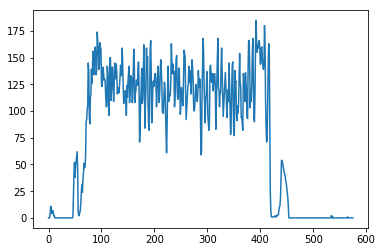

Row values


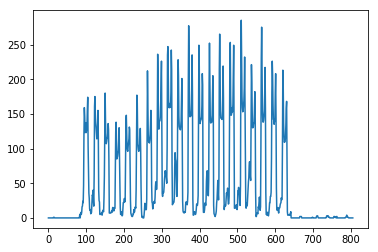

In [5]:
row_vals = imfinal.sum(axis=1)
col_vals = imfinal.sum(axis=0)

# Show the outputs
print('Column values')
plt.plot(col_vals)
plt.show()

print('Row values')
plt.plot(row_vals)
plt.show()

These are nice, but they're very noisy: there are lots of 'ups and downs'. It would be better if we can smooth out the lines a bit. Let's use a fancy function called a 'Savitzky-Golay filter'. Frankly I don't fully understand how it works myself, but it doesn't really matter: that's the beauty of using libraries that other people have created.

The only hard part here is that the Savitzky-Golay filter needs two parameters, and it's difficult to figure out what they should be, partly because they depend on the size of your image. The first number must be an odd number; experimenting suggests to me that it should be about 1/30 of the total height. The second number seems to work with '3'.

27


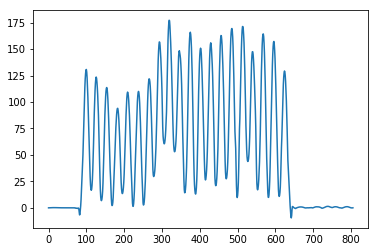

In [6]:
win_length = int(len(row_vals) / 30)

# Remember that the window length must be an odd number
# The % is the 'modulo' or 'remainder' operator: here it gives
# the remainder if win_length is divided by two.
# The += operator means 'add this to the current value of the variable'

if win_length % 2 == 0:
    win_length += 1

print(win_length)


smoothed = savgol_filter(row_vals, win_length, 3)
plt.plot(smoothed)

To find the lines, we want to find the peaks in the row values. This again is fairly easy to do with the SciKit signal processing library:

In [7]:
peaks, = argrelmax(smoothed, order=10)  # NOTE THE COMMA AFTER 'peaks'!

However, some of these are 'false' peaks, namely only small peaks caused by other things on the page. Let's count only those peaks which are greater than a particular value: we can try only those peaks that are at least one third of the highest peak. You may need to change this depending on your image.

In [8]:
min_peak_height = smoothed.max() / 3

are_true_peaks = smoothed[peaks] > min_peak_height
row_peaks = peaks[are_true_peaks]

print('Your script has found', len(row_peaks), 'lines of text in your image.')

Your script has found 20 lines of text in your image.


We can put all of this together into a single _function_. This means that we can define a set of instructions and re-use them later, rather than typing out the same thing again and again. In this case, we have called the function `process()`, and it takes one parameter, namely the filename `f`. To use the function after we have defined it, we simply store the filename in a variable (e.g. `filename`) and then tell Python to `process(filename)`

In [9]:
def process(f):
    print('Image %s:' % f)
    print('\tLoading...')
    
    # Threshold and mask the image. The code here is reproduced from 
    # 'Simple Image Segmentation with Scikit-Image': 
    # http://douglasduhaime.com/posts/simple-image-segmentation-with-scikit-image.html
    im = rgb2grey(imread(f))

    # find a dividing line between 0 and 255
    # pixels below this value will be black
    # pixels above this value will be white
    print('\tThresholding...' )
    val = filters.threshold_otsu(im)
    
    print('\tMasking...')
    # the mask object converts each pixel in the image to True or False
    # to indicate whether the given pixel is black/white
    mask = im < val

    # Remove any border noise
    clean_border = segmentation.clear_border(mask)

    # If the image is of a verso page then we flip it.
    # We assume that references without 'r' or 'v' are to pagination
    # Expects a reference matching \d+(r|v)?, i.e. one or more digits followed
    # by an r or v for foliation, or one or more digits for pagination.
        
    # Get the basename without extension
    fol = os.path.splitext(os.path.basename(f))[0].lower()

    try:
        if (fol[-1] == 'v'):
            print('\tFlipping...')
            imfinal = np.flip(clean_border, axis=1)
        elif (fol[-1] == 'r'):
            imfinal = clean_border
        elif (int(fol) % 2 == 0):
            print('\tFlipping...')
            imfinal = np.flip(clean_border, axis=1)
        else:
            imfinal = clean_border
    except ValueError:
        # I assume if we're here then it's because the cast to integer threw
        # an exception meaning that the folio reference doesn't match \d+(r|v)?
        print('Page or folio format not recognised: treating as recto page')
        imfinal = clean_border

    print('\tCalculating profile...')      
    row_vals = imfinal.sum(axis=1)
    col_vals = imfinal.sum(axis=0)
    
    print('\tFinding peaks...')
    # About 1/30 of the total seems to work for the window length.
    # Remember that the win length must be odd
    win_length = int(len(row_vals) / 30)

    if win_length % 2 == 0:
        win_length += 1

    smoothed = savgol_filter(row_vals, win_length, 3)

    # TODO: need a way of calculating the order parameters
    peaks, = argrelmax(smoothed, order=10)
    
    min_peak_height = smoothed.max() / 3

    are_true_peaks = smoothed[peaks] > min_peak_height
    row_peaks = peaks[are_true_peaks]

    local_lines_per_page = len(row_peaks)
    
    print('\tFound', local_lines_per_page, 'lines')
    
    return local_lines_per_page

Now that we have it in a function, it's very easy to create a loop and run the function on each image in the directory:

In [ ]:
for f in filelist:
    result = process(f)
    if result != None:
        lines_per_page.append(result)

And now we can plot the results for the entire directory:

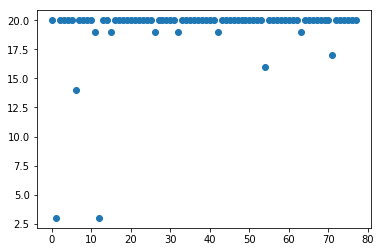

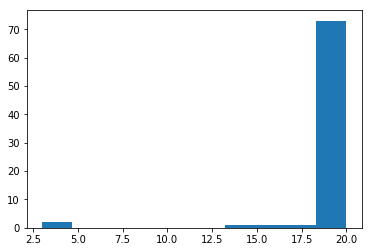

In [11]:
plt.plot(lines_per_page, 'o')
plt.show()

plt.hist(lines_per_page)
plt.show()

Do you understand these results and what they show? If you run the script for CCCC 44, you will find five pages which are very different from the rest. By looking through the printout you should be able to see which ones they are. Have a look at the images: can you see why these pages are different?

This shows an important principle of Digital Humanities. On the face of it, we could count ourselves how many lines there are to a page. However, we can use the software to quickly skim through an entire manuscript in a matter of seconds and to tell us where interesting things are happening, to focus our attention on things that are unusual. If we do this at scale then it can be very useful indeed.

---
![Licence Creative Commons](https://i.creativecommons.org/l/by/4.0/88x31.png)
This work (the contents of this Jupyter Python notebook) is licenced under a [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)